# Calculating event rates for GRB from BATSE
### Author: Hannah Gulick

edited for Magnetar Detection Rates from GBM by Kaylie Ching

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import lmfit as lmfit

C:\Users\kayli\AppData\Local\Temp\ipykernel_49500\1753215200.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


"GBM is an all-sky monitor with an 8 sr field of view consisting of 12 NaI detectors, covering an energy range from 8 keV to 1 MeV, and 2 BGO detectors, covering 0.2–40 MeV (Meegan et al. 2009). GBM has three data types, of which two (CTIME and CSPEC) are continuously recorded and one (time-tagged event data, or TTE) is recorded only after GBM had triggered on a burst or other selected time intervals during most of the catalog period. This configuration changed after 2012 November, and currently GBM is recording TTE data continuously. While CSPEC data have good spectral resolution (128 energy channels over the full energy range), its temporal resolution of 1.024 s is too long for the ∼0.1 s long magnetar bursts. The temporal resolution of CTIME data (64 ms) is better suited in this respect, but the spectral resolution (8 energy channels) is not sufficient to perform detailed spectral analysis. TTE data have the highest temporal (2 μs) and energy (128 energy channels) resolution, and are therefore perfectly suited for magnetar burst analyses. The downside is that this data type is typically only available from ∼30 s before a burst trigger to ∼300 s afterwards, followed by another ∼300 during which no new trigger can take place. For further details on GBM and its data products, see Meegan et al."
--from article: https://iopscience.iop.org/article/10.1088/0067-0049/218/1/11#apjs512933s3

In [45]:
df = pd.read_csv('GBM_Magnetar_burst.csv')
t90i = df["T_90"]
t90 = t90i.str[:3] #taking out unecessary tolerances

flux1 = df["4ms Peak Flux"]
for i in range(len(flux1)):
    if flux1[i] == 'cdots':
        t90 = t90.drop(i) #dropping same timestamps so lengths are the same
        flux1 = flux1.drop(i)

#droping units
flux = flux1.str[:8] #taking out tolerances
flux

10     1.61E-06
11     4.69E-06
12     3.63E-06
13     5.25E-06
14     3.74E-06
         ...   
379    2.71E-06
380    6.40E-06
381    1.37E-05
382    2.25E-05
383    4.78E-06
Name: 4ms Peak Flux, Length: 374, dtype: object

In [86]:
#making entries in the time and flux arrays into floats
t90 = pd.to_numeric(t90,errors = 'coerce')
flux  = pd.to_numeric(flux,errors = 'coerce')

t90= t90.fillna(0)
flux = flux.fillna(0)

In [89]:
#printing the number of data entries to cross check with how many i expected in the catalog
print('There are %s magnetar bursts in the catalog.' %(len(t90)))

There are 374 magnetar bursts in the catalog.


Text(0.5, 1.0, 'Distribution of Events in Catalog')

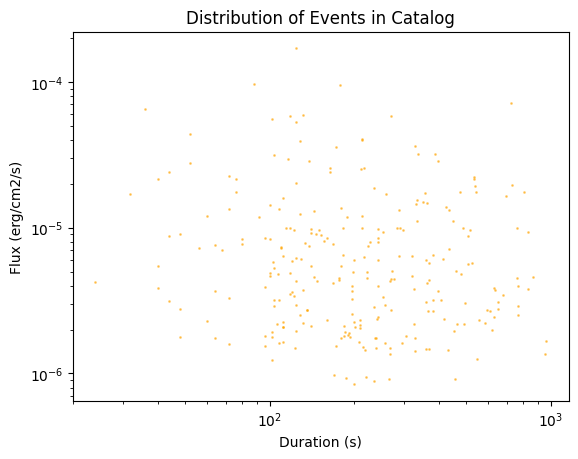

In [90]:
##plotting magnetar distribution
plt.scatter(t90, flux, s = 1, c = 'orange', alpha = 0.5)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Duration (s)')
plt.ylabel('Flux (erg/cm2/s)')
plt.title("Distribution of Events in Catalog")

In [51]:
#effective area of instrument in cm
area = 200 
#found a graph online that said the effective area of GBM was about 200 cm^2 ..
# https://www.google.com/search?sca_esv=4117407177bffc2f&rlz=1C1JZAP_enUS967US968&q=BATSE+effective+area&tbm=isch&source=lnms&prmd=ihvsnmbtz&sa=X&ved=2ahUKEwiJx73S85iEAxXtL0QIHUIrBAIQ0pQJegQICxAB&biw=1383&bih=729&dpr=2.5#imgrc=6R2f1DHRYlskQM

In [91]:
#converting from erg/cm/s to photon/s??
#1 erg = 6.242e+11 eV
magnetar_counts = flux*6.242e+11/ area
magnetar_counts


10      5024.81
11     14637.49
12     11329.23
13     16385.25
14     11672.54
         ...   
379     8457.91
380    19974.40
381    42757.70
382    70222.50
383    14918.38
Name: 4ms Peak Flux, Length: 374, dtype: float64

In [122]:
def lmfit_exp(A, x, tau):
    return A*np.exp(-x/tau)

def plot_fit_hist(data, bin_num, x_label):
    
    '''
    Inputs:
        data = data array (i.e. fluence or photon/s)
        bin_num = number of bins
        to highlight the lower fluence end of the histrogram.
        x_label = label for x-axis (i.e. fluence (with UNITS), or photons/s)
    '''
    
    #making a histogram
    counts,bin_edges = np.histogram(data, bin_num, density = False)
    #finding center of bins for plotting
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    
    #fitting an exponential to the histogram
    mod = lmfit.models.ExponentialModel()
    pars = mod.guess(counts, x=bin_centres)
    out = mod.fit(counts, pars, x=bin_centres)
    #print(out.fit_report())
    
    
    #reading out results
    results = out.fit_report().split()
    amp = float(results[45])
    amp_err = float(results[47])
    decay = float(results[53])
    decay_err = float(results[55])
    print(results)
    print(results[47])
    ### PLOTTING ####

    x_new = np.linspace(min(bin_centres), max(bin_centres), 500)
    # histogram on linear scale
    plt.figure(figsize = (11,8))
    plt.subplot(211)
    hist, bins, _ = plt.hist(data, density = False, bins=bin_num, fc = 'None', ec = 'black')
    plt.plot(x_new, lmfit_exp(amp, x_new, decay), color = 'red', linestyle = 'dashed', label="Exponential Fit")
    plt.ylabel('Number of magnetars', fontsize = 19)
    #plotting a vertical line indicating what our estimated background rate is for BTO.
    #NOTE not a great direct comparison bc BATSE, GBM, etc. will have their own, different background rates
    plt.axvline(60.9, linestyle = 'dotted', color = 'grey', alpha = 0.9, label = 'Background Rate: 60.9 count/s')
    plt.xlabel(x_label, fontsize = 19)
    plt.xticks(fontsize = 17)
    plt.yticks(fontsize = 17)
    plt.legend(fontsize = 15)
    plt.show()

    print('The exponential fit parameters are: amplitude = %.2f +/- %.4f, decay = %.2f +/- %.2f' %(amp, amp_err, decay, decay_err))

    return bins, hist
    
    

['[[Model]]', 'Model(exponential)', '[[Fit', 'Statistics]]', '#', 'fitting', 'method', '=', 'leastsq', '#', 'function', 'evals', '=', '41', '#', 'data', 'points', '=', '100', '#', 'variables', '=', '2', 'chi-square', '=', '1498.81680', 'reduced', 'chi-square', '=', '15.2940490', 'Akaike', 'info', 'crit', '=', '274.726109', 'Bayesian', 'info', 'crit', '=', '279.936449', 'R-squared', '=', '0.91037521', '[[Variables]]', 'amplitude:', '94.8752268', '+/-', '4.14373315', '(4.37%)', '(init', '=', '0.2565886)', 'decay:', '19831.2448', '+/-', '1217.43166', '(6.14%)', '(init', '=', '13069.48)', '[[Correlations]]', '(unreported', 'correlations', 'are', '<', '0.100)', 'C(amplitude,', 'decay)', '=', '-0.7195']
4.14373315


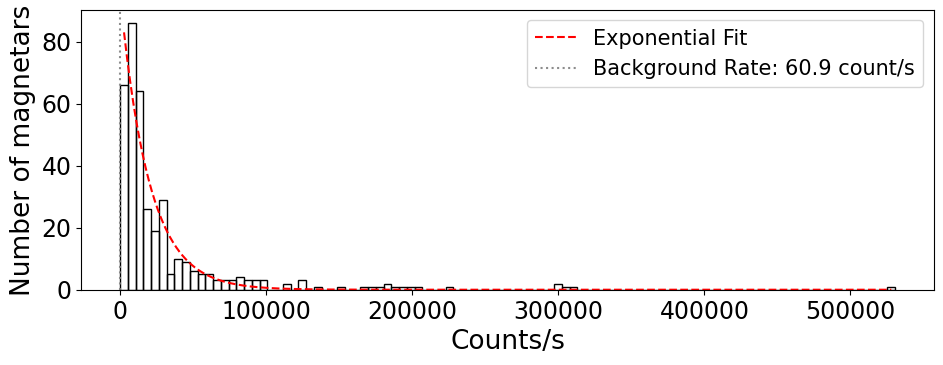

The exponential fit parameters are: amplitude = 94.88 +/- 4.1437, decay = 19831.24 +/- 1217.43


In [123]:
bins, histmag = plot_fit_hist(magnetar_counts, 100, 'Counts/s')

<Axes: title={'center': 'magnetar counts histogram'}, xlabel='counts/s', ylabel='# of bursts'>

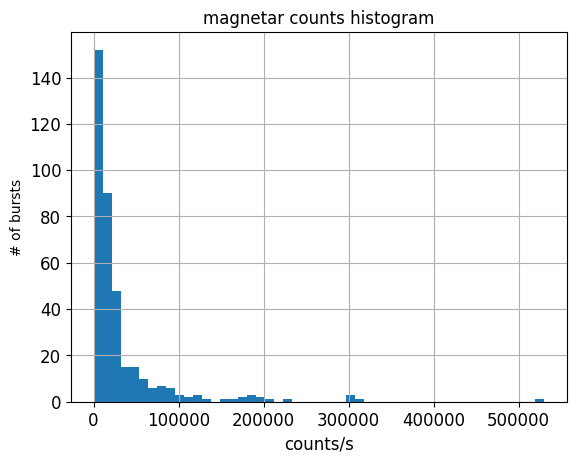

In [94]:
figure2 = magnetar_counts.hist(bins = 50)
plt.xlabel("counts/s", fontsize = 12)
plt.ylabel("# of bursts")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("magnetar counts histogram")
figure2

In [95]:
#GBM duration == between 2008 July and 2013 June
GBMdur = 1825

In [96]:
print('The rate of magnetar detections made by GBM was %.2f GRB/day.' %(len(t90)/GBMdur))

The rate of magnetar detections made by GBM was 0.20 GRB/day.


In [97]:
#calculating how many days between magnetar
aveinterval = (1/(len(t90)/GBMdur))
print('Therefore, an average time between magnetar bursts is %.3f days' %(aveinterval))

Therefore, an average time between magnetar bursts is 4.880 days


In [98]:
magnetarperday = magnetar_counts/aveinterval

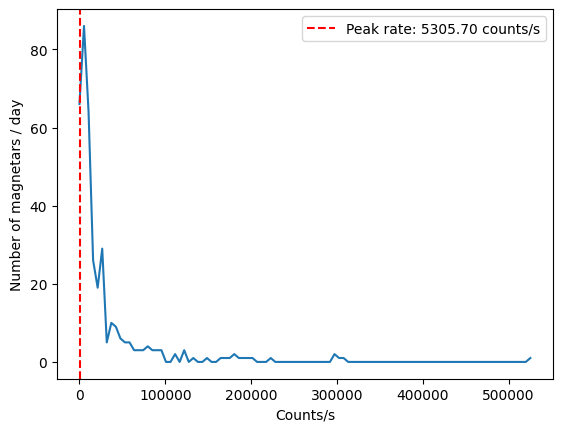

In [99]:
#plotting distribution for long GRB
plt.plot(bins[:-1], histmag)
plt.ylabel('Number of magnetars / day')
plt.xlabel('Counts/s')

#finding the event rate that occurs most frequently
plt.axvline(max(histmag), linestyle = 'dashed', color = 'red', label = 'Peak rate: %.2f counts/s' %(bins[list(histmag).index(max(histmag))]))
plt.legend()
plt.show()

hannah's explanation: To find the total estimated data rates from GRB events in a single day, we need to estimate the total number of counts from GRB. We can do this using our distribution above, which tells use exactly the frequency we would expect to have GRB with different count rates. We can 'simulate' GRB for a given observation time by sampling the x-axis in the plot above, where we weight our choices by the y-axis value. This just means that the higher the y-axis value (i.e. the Number of GRB/day), the more likely it is to get the corresponding x-axis value (i.e. the counts/s). For example, the count/rate of 471 counts/s has the highest rate of GRB/day and is therefore the most likely count rate in our weighted distribution.

In [110]:
norm_mag_day = np.array(histmag)/sum(histmag)

In [111]:
# cross check that this equals 1:
print(sum(norm_mag_day))

1.0000000000000004


In [112]:
#selecting a single GRB event. Each time you execute this cell you will get a different GRB
rand_counts = np.random.choice(bins[:-1], p=norm_mag_day)
print('Random counts value:', rand_counts)

Random counts value: 68974.1


In [113]:
#the effective exposure time for the calculation
effect_exp = 5 #days
#calculating how many GRB we expect over this exposure time
num_mag_over_exp_calc = 5/aveinterval
print('There will be ~%.2f GRB over the effective exposure time of %s days.' %(num_GRB_over_exp_calc, effect_exp))

There will be ~1.02 GRB over the effective exposure time of 5 days.


In [114]:
num_mag_over_exp = int(num_mag_over_exp_calc)

In [115]:
rand_mag_counts = []
for i in range(num_mag_over_exp):
    rand_mag_counts.append(np.random.choice(bins[:-1], p=norm_mag_day))

In [109]:
print('Our %s simulated GRB have rates of: %s counts/s' %(num_mag_over_exp, rand_mag_counts))

Our 1 simulated GRB have rates of: [5305.700000000001] counts/s


In [116]:
zero_array = np.zeros(100)

In [117]:
magarraysim = zero_array
spacing = len(zero_array)/num_mag_over_exp
for i in range(num_mag_over_exp):
    magarraysim[int(i*spacing+spacing/2)] = rand_mag_counts[i]

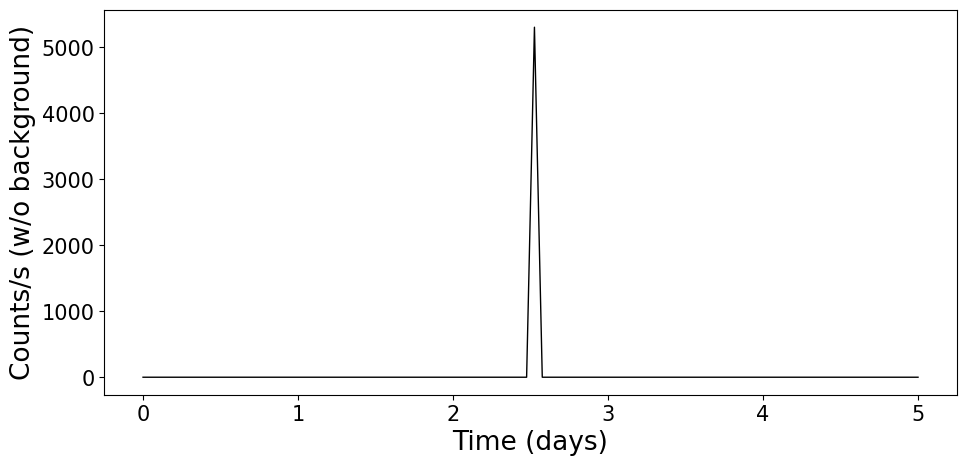

In [118]:
time = np.linspace(0, 5, 100)

plt.figure(figsize = (11, 5))
plt.plot(time, magarraysim, color = 'black', linewidth = 1)
plt.xlabel('Time (days)', fontsize = 19)
plt.ylabel('Counts/s (w/o background)', fontsize = 19)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
#plt.yscale('log')
plt.show()

"An easy estimate can be made by scaling the effective are of your instrument with BTO's effective area. Try recreating all these plots but scale them with BTO's effective area to better show the rates we expect with our instrument. Hint 1: BTO's effective area on one long side is 28.88 cm2 and on the top is 14.44 cm2 (these would be separate scalings that just indicate which side of the detector the GRB entered from---you don't need to combine). Hint 2: your numbers should go down."

In [120]:
BTO1 = 22.88 #cm^2

['[[Model]]', 'Model(exponential)', '[[Fit', 'Statistics]]', '#', 'fitting', 'method', '=', 'leastsq', '#', 'function', 'evals', '=', '41', '#', 'data', 'points', '=', '100', '#', 'variables', '=', '2', 'chi-square', '=', '1518.64117', 'reduced', 'chi-square', '=', '15.4963385', 'Akaike', 'info', 'crit', '=', '276.040106', 'Bayesian', 'info', 'crit', '=', '281.250446', 'R-squared', '=', '0.90925489', '[[Variables]]', 'amplitude:', '94.8678244', '+/-', '4.17174709', '(4.40%)', '(init', '=', '0.2553926)', 'decay:', '173296.754', '+/-', '10711.3519', '(6.18%)', '(init', '=', '114262.8)', '[[Correlations]]', '(unreported', 'correlations', 'are', '<', '0.100)', 'C(amplitude,', 'decay)', '=', '-0.7195']
4.17174709


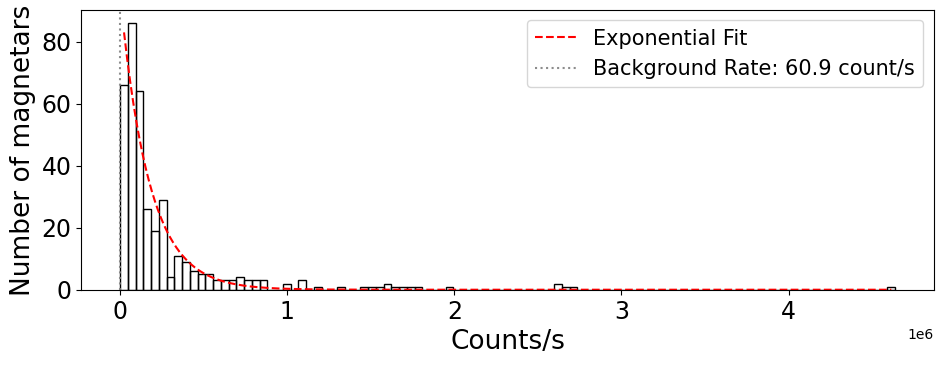

The exponential fit parameters are: amplitude = 94.87 +/- 4.1717, decay = 173296.75 +/- 10711.35


In [124]:
magnetar_countsBTO1 = flux*6.242e+11/ BTO1
binsBTO1, histmagBTO1 = plot_fit_hist(magnetar_countsBTO1, 100, 'Counts/s')

In [ ]:
BTO2 = 14.44 #cm^2